# Appendix: Grover's Algorithm



In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# Load saved credentials
service = QiskitRuntimeService()

In [3]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

In [4]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

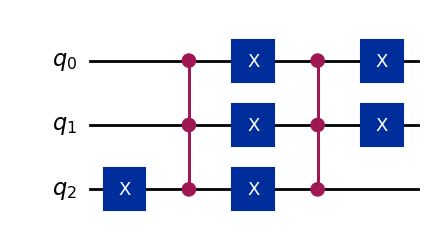

In [5]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

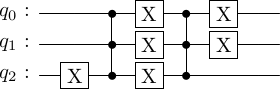

In [6]:
oracle.draw(output='latex', style='iqp')

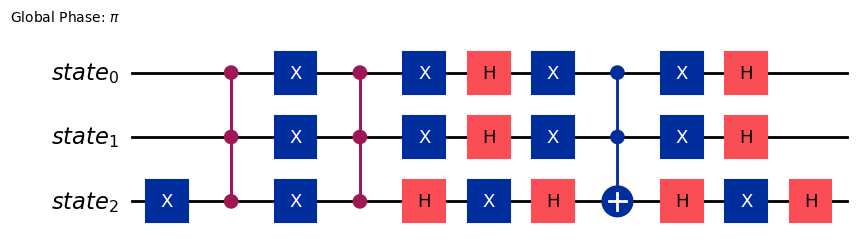

In [13]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [14]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

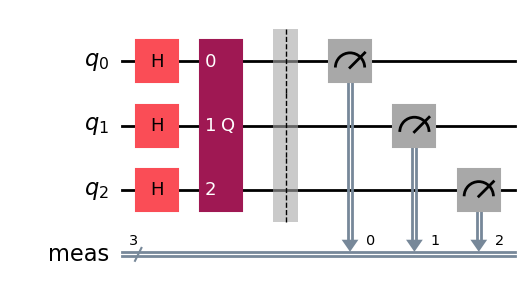

In [15]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

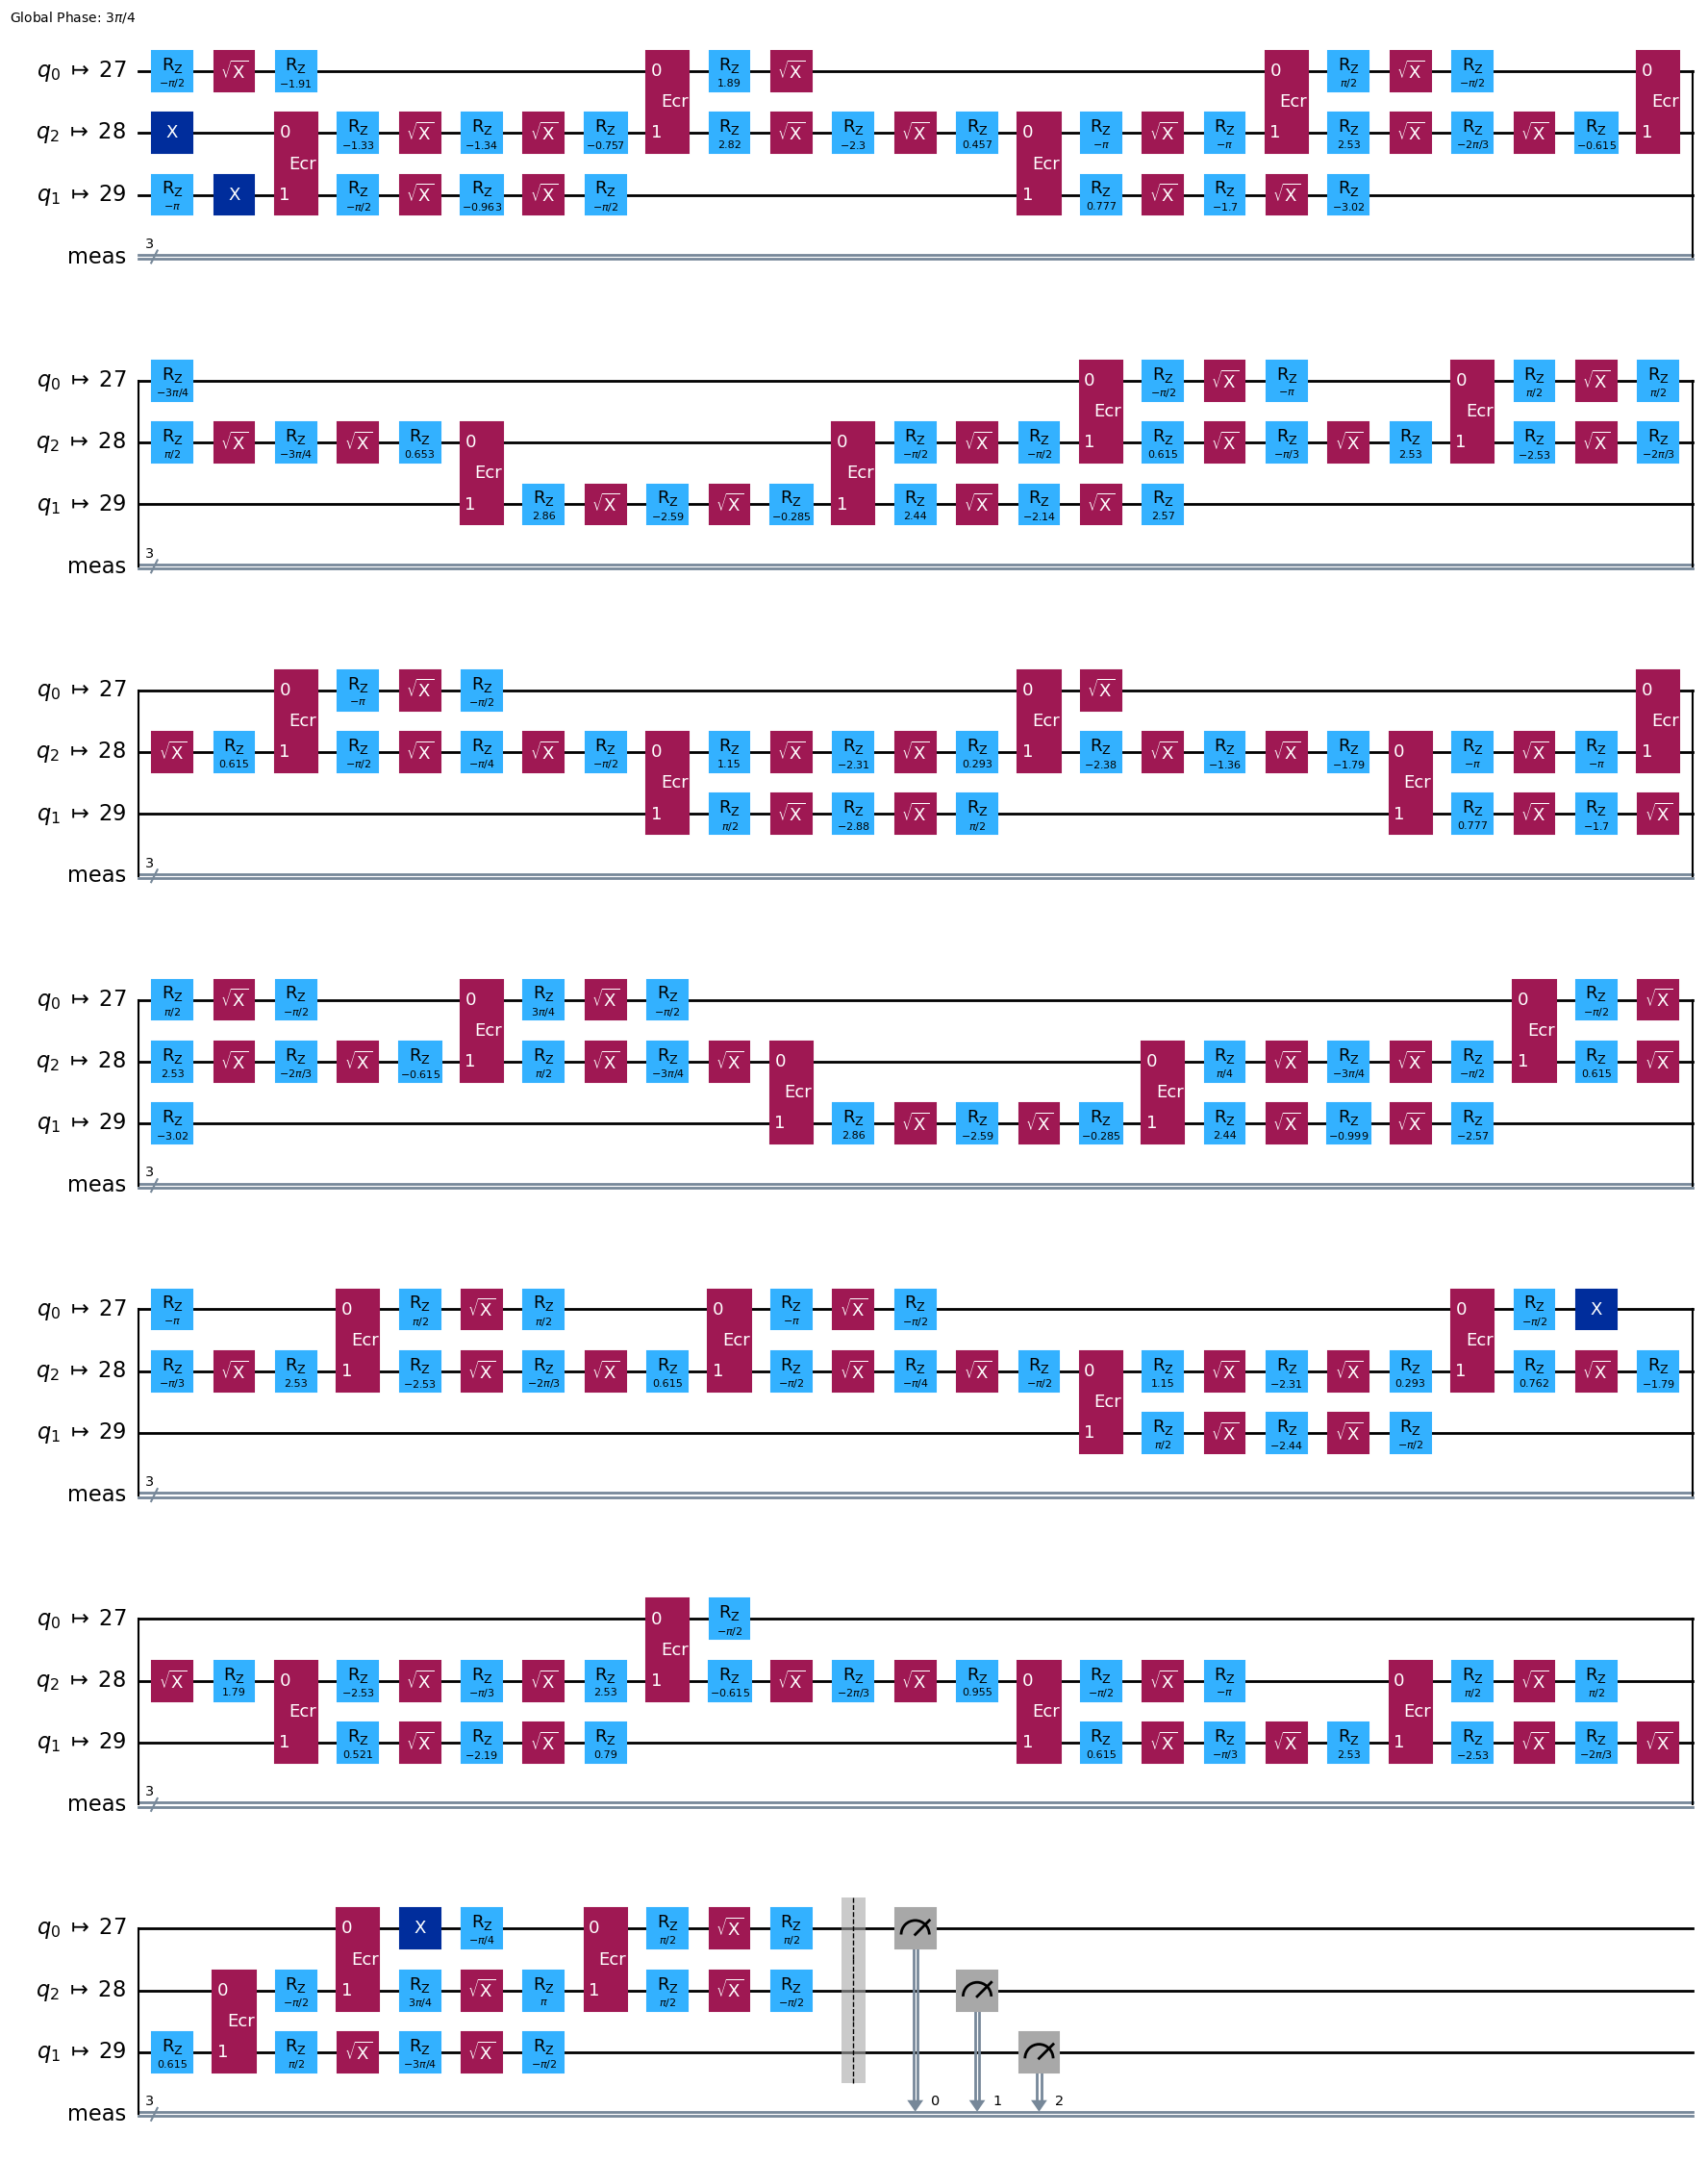

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [18]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(backend=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

In [ ]:
plot_distribution(dist)

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt

Scatter plot


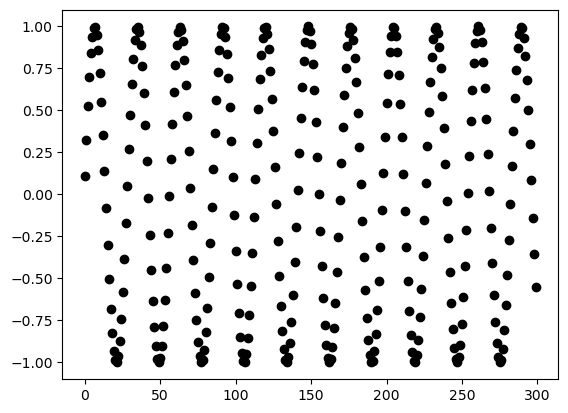

Linear interpolation


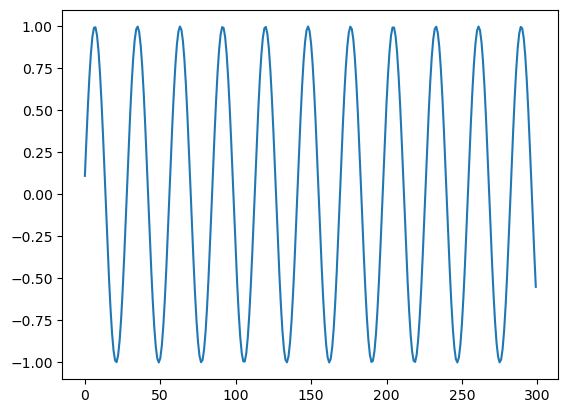

In [9]:
%matplotlib inline

theta = 1 / 9  # angle in radians
t = np.arange(0, 300, 1)  # (start, stop, step)
y = np.sin((2 * t + 1) * theta)

print("Scatter plot")
plt.plot(t, y, "o", color="black")
plt.show()

print("Linear interpolation")
plt.plot(t, y)
plt.show()

In [10]:
for n in range(1, 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(1 / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, p))

2	 0.5000000000
4	 1.0000000000
8	 0.9453125000
16	 0.9613189697
32	 0.9991823155
64	 0.9965856808
128	 0.9956198657
256	 0.9999470421
512	 0.9994480262
1024	 0.9994612447
2048	 0.9999968478
4096	 0.9999453461
8192	 0.9999157752
16384	 0.9999997811
32768	 0.9999868295
65536	 0.9999882596
131072	 0.9999992587
262144	 0.9999978382
524288	 0.9999997279


In [11]:
# We'll start the loop with n=2 to stay within the domain of arcsin.
# (Note that we can't have 4 solutions when n=1.)

for n in range(2, 20):
    N = 2**n
    old_theta = np.arcsin(np.sqrt(1 / N))
    new_theta = np.arcsin(np.sqrt(4 / N))
    t = math.floor(np.pi / (4 * old_theta))
    p = np.sin((2 * t + 1) * new_theta) ** 2
    print("%d\t %12.10f" % (N, p))

4	 1.0000000000
8	 0.5000000000
16	 0.2500000000
32	 0.0122070313
64	 0.0203807689
128	 0.0144530758
256	 0.0000705058
512	 0.0019310741
1024	 0.0023009083
2048	 0.0000077506
4096	 0.0002301502
8192	 0.0003439882
16384	 0.0000007053
32768	 0.0000533810
65536	 0.0000472907
131072	 0.0000030066
262144	 0.0000086824
524288	 0.0000010820


In [12]:
s = 7  # Number of solutions. This can be any positive integer.

# The loop starts with the smallest value of n that allows s solutions.
for n in range(math.ceil(math.log2(s)), math.ceil(math.log2(s)) + 20):
    N = 2**n
    theta = np.arcsin(np.sqrt(s / N))
    t = math.floor(np.pi / (4 * theta))
    p = np.sin((2 * t + 1) * theta) ** 2
    print("%d\t %12.10f" % (N, np.sin((2 * t + 1) * theta) ** 2))

8	 0.8750000000
16	 0.6835937500
32	 0.9877929688
64	 0.9869401455
128	 0.9933758959
256	 0.9942813445
512	 0.9977678832
1024	 0.9999963373
2048	 0.9999257666
4096	 0.9983374778
8192	 0.9995465664
16384	 0.9995822234
32768	 0.9999531497
65536	 0.9998961946
131072	 0.9999998224
262144	 0.9999745784
524288	 0.9999894829
1048576	 0.9999939313
2097152	 0.9999979874
4194304	 0.9999986243


In [19]:
# IBM qiskit related 
from qiskit import BasicAer
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
# string manipulation
import re, string

ImportError: cannot import name 'BasicAer' from 'qiskit' (/Users/skingham/Library/Anaconda/envs/py312_qiskit/lib/python3.12/site-packages/qiskit/__init__.py)